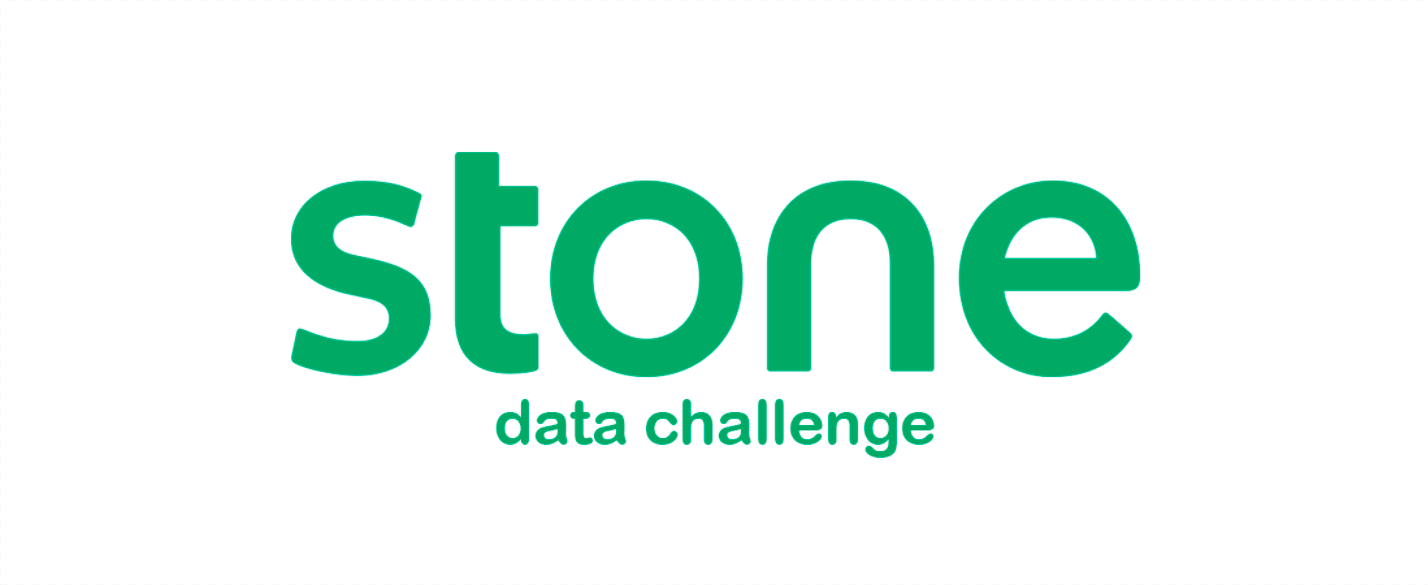

Nesse notebook, eu fiz a engenharia de features e o pré-processamento dos dados. Devido ao alto número de features categóricas - algumas delas com centenas de categorias - no dataset original, realizei o pré-processamento com algoritmos tree-based em mente, uma vez que eles lidam melhor com elas. 

O script resultante desse notebook é chamado `preprocessing.py` e ele retorna o mesmo DataFrame final.

### **Resumo do que foi realizado:**

* **Features Categóricas**
    * Redução do número de categorias nas variáveis MCC e sub_segmentos
        * Realizado por meio de agrupamento a partir de um threshold mínimo de participação
    * Adição de colunas 'is_missing' ao lado de categorias que possuíam valores missing.
    * Adição de coluna 'Região', agrupando os estados
    * Label-Encoding em features nominais
        * Decidi por ele devido ao número de categorias p/ feature, o que causaria MUITAS colunas novas utilizando one-hot-encoding resultando em um dataset sparse - que não funciona muito bem em emsembles. 
    * Ordinal-Encoding em features ordinais


* **Features Datetime**
    * Adição de feature "tempo entre criação de conta e primeira transação"
        * Normalização da feature usando boxcox devido ao alto número de 0s
    * Encoding no mês-ano da StoneCreatedDate e drop da StoneFirstTransaction
    * Decompose do mes-referencia em mês, trimestre e ano.


* **Features Contínuas**
    * Drop na TPV-Estimado
    * Criação de Lags e Diffs dos TPV-mensais anteriores

In [1]:
# Import libs

# Wrangling e Analysis
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Dataviz
import matplotlib.pyplot as plt
import seaborn as sns

# Stats
from scipy.stats import boxcox

from helper import dict_regioes, dict_ordinal_dates

# Styling dos plots e dos DataFrames
sns.set_style('white')
sns.set_context('talk')
g = sns.color_palette('viridis_r', 30)[9]
plt.rc("axes.spines", top=False, right=False)

pd.set_option('display.max_rows', None)

In [2]:
# Import nos datasets
cadastrais = pd.read_csv('data/cadastrais-limpo.csv', parse_dates = ['StoneCreatedDate', 'StoneFirstTransactionDate'])
cadastrais.drop("Unnamed: 0", axis = 1, inplace = True)

tpv_mensais = pd.read_csv('data/tpv-mensais-limpo.csv', parse_dates = ['mes_referencia'])
tpv_mensais.drop("Unnamed: 0", axis = 1, inplace = True)

In [3]:
tpv_mensais[tpv_mensais.TPV_mensal < 0]

,id,mes_referencia,TPV_mensal
2163469,151460,2017-08-31,-577.940
2717344,184854,2017-08-31,-1090.640
2780892,188600,2017-08-31,-1101.485


## Ordinal Encoding: Porte e Persona

### Porte

In [4]:
cadastrais_label_encoded = cadastrais.copy()

cadastrais_label_encoded['porte'].value_counts()

10k-25k      75871
25k-50k      44333
5k-10k       39120
50k-100k     20443
2.5k-5k      11217
100k-500k     8765
0-2.5k        5679
500k+          405
Name: porte, dtype: int64

In [5]:
# Label encoding considerando Ordinal

porte_encoding = {
                '0-2.5k': 1,
                '2.5k-5k': 2,
                '5k-10k': 3,
                '10k-25k': 4,     
                '25k-50k': 5,    
                '50k-100k': 6,   
                '100k-500k': 7,   
                '500k+': 8,    
                }

cadastrais_label_encoded['porte'] = cadastrais_label_encoded['porte'].replace(porte_encoding)
cadastrais_label_encoded['porte'].value_counts()

4    75871
5    44333
3    39120
6    20443
2    11217
7     8765
1     5679
8      405
Name: porte, dtype: int64

### Persona

In [6]:
cadastrais_label_encoded['persona'].value_counts()

SMB - Pequeno Porte e Ticket Medio    42708
SMB - Pequeno Porte e Ticket Baixo    40522
SMB - Medio Porte e Ticket Baixo      28639
SMB - Pequeno Porte e Ticket Alto     24924
Outro                                 18437
SMB - Medio Porte e Ticket Medio      17408
SMB - Medio Porte e Ticket Alto       15393
Pequeno Empreendedor                   7689
SMB - Grande Porte e Ticket Baixo      4599
SMB - Grande Porte e Ticket Alto       1959
Micro Empreendedor                     1800
SMB - Grande Porte e Ticket Medio      1753
Digital - Micro                           2
Name: persona, dtype: int64

In [7]:
# Digital - Micro -> Micro Empreendedor

cadastrais_label_encoded['persona'] = cadastrais_label_encoded['persona'].replace({'Digital - Micro':'Micro Empreendedor'})
cadastrais_label_encoded['persona'].value_counts()

SMB - Pequeno Porte e Ticket Medio    42708
SMB - Pequeno Porte e Ticket Baixo    40522
SMB - Medio Porte e Ticket Baixo      28639
SMB - Pequeno Porte e Ticket Alto     24924
Outro                                 18437
SMB - Medio Porte e Ticket Medio      17408
SMB - Medio Porte e Ticket Alto       15393
Pequeno Empreendedor                   7689
SMB - Grande Porte e Ticket Baixo      4599
SMB - Grande Porte e Ticket Alto       1959
Micro Empreendedor                     1802
SMB - Grande Porte e Ticket Medio      1753
Name: persona, dtype: int64

In [8]:
# Labels considerando o EDA -> de acordo com a distribuição do TPV-Mensal entre as personas

persona_encoding = {
                'Micro Empreendedor': 1,
                'Pequeno Empreendedor': 2,
    
                'SMB - Pequeno Porte e Ticket Baixo': 5,
                'SMB - Pequeno Porte e Ticket Medio': 6,     
                'SMB - Pequeno Porte e Ticket Alto': 7,
    
                'Outro': 8,
    
                'SMB - Medio Porte e Ticket Baixo': 10,   
                'SMB - Medio Porte e Ticket Medio': 11,   
                'SMB - Medio Porte e Ticket Alto': 12,
    
                'SMB - Grande Porte e Ticket Baixo': 15,   
                'SMB - Grande Porte e Ticket Medio': 16,   
                'SMB - Grande Porte e Ticket Alto': 17,  
                }

cadastrais_label_encoded['persona'] = cadastrais_label_encoded['persona'].replace(persona_encoding)
cadastrais_label_encoded['persona'].value_counts()

6     42708
5     40522
10    28639
7     24924
8     18437
11    17408
12    15393
2      7689
15     4599
17     1959
1      1802
16     1753
Name: persona, dtype: int64

## Datetime

### Tempo entre criação de Conta e Transação

In [9]:
# Calcula a Diferença entre criação de Conta e Transação em dias

cadastrais_label_encoded['diff_FirstTransaction_Created'] = (cadastrais_label_encoded['StoneFirstTransactionDate'] - \
                                                             cadastrais_label_encoded['StoneCreatedDate']).dt.days

# Check por valores < 0

print(f"Número de Rows < 0: {len(cadastrais_label_encoded[cadastrais_label_encoded['diff_FirstTransaction_Created'] < 0])}")

Número de Rows < 0: 59


In [10]:
# Calcula a mediana e coloca nos valores < 0

diff_median = cadastrais_label_encoded.loc[:, 'diff_FirstTransaction_Created'].median()

cadastrais_label_encoded.loc[:, 'diff_FirstTransaction_Created'] = np.where(cadastrais_label_encoded['diff_FirstTransaction_Created'] < 0,
                                                                            diff_median, cadastrais_label_encoded['diff_FirstTransaction_Created'])

In [11]:
# Check por valores < 0

print(f"Número de Rows < 0: {len(cadastrais_label_encoded[cadastrais_label_encoded['diff_FirstTransaction_Created'] < 0])}")

Número de Rows < 0: 0


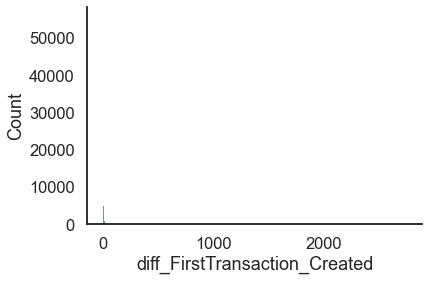

In [12]:
# Check na distribuição desses valores

sns.histplot(x = cadastrais_label_encoded['diff_FirstTransaction_Created'], discrete = True);

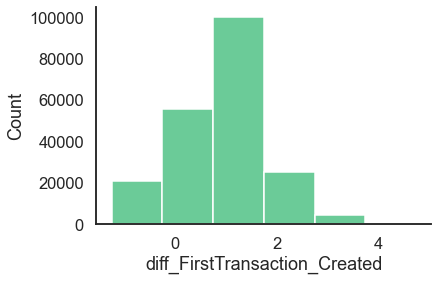

In [13]:
# Aplica transformação boxcox pra curva se aproximar da normal (muitos valores zero pra aplicar log)

diff_trans_created_norm, _ = boxcox(cadastrais_label_encoded['diff_FirstTransaction_Created'].add(0.5))

cadastrais_label_encoded.loc[:, 'diff_FirstTransaction_Created'] = diff_trans_created_norm

sns.histplot(x = cadastrais_label_encoded['diff_FirstTransaction_Created'],
             discrete = True, color = g);

### StoneCreatedDate -> MM-YYYY, drop FirstTransaction

In [14]:
cadastrais_label_encoded.loc[:, 'StoneCreatedDate'] = cadastrais_label_encoded['StoneCreatedDate']\
                                                                      .apply(lambda x: f'{x.year}-{x.month}')

cadastrais_label_encoded = cadastrais_label_encoded.drop(['StoneFirstTransactionDate', 'TPVEstimate'], axis = 1)

cadastrais_label_encoded.loc[:, 'StoneCreatedDate'] = cadastrais_label_encoded['StoneCreatedDate'].replace(dict_ordinal_dates)

## Missing Values

### is_missing column

In [15]:
# cadastrais_label_encoded = Cria coluna is_missing com valor = 1 se tiver Missing Value na coluna ao lado

for col in ['MacroClassificacao', 'segmento', 'sub_segmento', 'Estado']:
    cadastrais_label_encoded[f'is_missing_{col}'] = np.where(cadastrais_label_encoded[col] == 'Missing Value',
                                                            1, 0)
    
cadastrais_label_encoded = cadastrais_label_encoded[['id', 'MCC', 'MacroClassificacao', 'is_missing_MacroClassificacao',
                                                    'segmento','is_missing_segmento', 'sub_segmento', 'is_missing_sub_segmento',
                                                    'persona', 'porte', 'tipo_documento', 'Estado', 'is_missing_Estado',
                                                     'tem_duplicados', 'StoneCreatedDate', 'diff_FirstTransaction_Created']]

## Estados

In [16]:
# Map regiões aos estados

cadastrais_label_encoded['Região'] = cadastrais_label_encoded['Estado'].replace(dict_regioes)

cadastrais_label_encoded.head()

,id,MCC,MacroClassificacao,is_missing_MacroClassificacao,segmento,is_missing_segmento,sub_segmento,is_missing_sub_segmento,persona,porte,tipo_documento,Estado,is_missing_Estado,tem_duplicados,StoneCreatedDate,diff_FirstTransaction_Created,Região
0,1,5942.0,Varejo,0,"Livrarias, Papelarias, Gráficas e Bancas",0,Livrarias e Papelarias,0,11,6,PJ,MG,0,0,82,0.386468,Sudeste
1,2,5231.0,Bens duráveis,0,Materiais de Construção,0,Materiais de Construção,0,7,4,PF,RS,0,0,98,0.386468,Sul
2,3,5411.0,Supermercado/Farmácia,0,Supermercados,0,Supermercados,0,2,2,PF,RJ,0,0,87,2.011777,Sudeste
3,4,4215.0,Serviços,0,Logística e Mobilidade,0,Delivery e Entrega,0,11,5,PJ,RJ,0,0,67,1.082861,Sudeste
4,5,5698.0,Serviços,0,Serviços de Beleza e Estética,0,Salão de Beleza,0,6,3,PF,PE,0,0,83,-0.753765,Nordeste


## Redução do Número de  Categorias

### MCC, segmento e sub_segmento

In [17]:
# Se > threshold, muda a categoria para 'outro'

for col, threshold in zip(['MCC', 'sub_segmento'], [0.0005, 0.005]):
    
    value_count = cadastrais_label_encoded[col].value_counts(normalize = True)

    cats_below_threshold = np.array(value_count[value_count < threshold].index)

    cadastrais_label_encoded.loc[:, col] = ['Outro' 
                                            if x in cats_below_threshold
                                            else x
                                            for x in cadastrais_label_encoded[col]]

## Label Encoding

In [18]:
# MCC, MacroClassificacao, segmento, sub_segmento, tipo_documento, Estado, Região

for col in ['MCC', 'MacroClassificacao', 'segmento', 'sub_segmento', 'tipo_documento', 'Estado', 'Região']:
    
    cadastrais_label_encoded.loc[:, col] = cadastrais_label_encoded[col].apply(lambda x: str(x))
    le = LabelEncoder()
    le.fit(cadastrais_label_encoded[col])
    
    cadastrais_label_encoded.loc[:, col] = le.transform(cadastrais_label_encoded[col])

## Criando o Dataset Modelo

In [19]:
# Decompose no mes_referencia -> Ano, Trimestre e Mês

tpv_mensais = tpv_mensais.sort_values(['id','mes_referencia'])
tpv_mensais['Mês'] = tpv_mensais['mes_referencia'].dt.month
tpv_mensais['Trimestre'] = tpv_mensais['mes_referencia'].dt.quarter
tpv_mensais['Ano'] = tpv_mensais['mes_referencia'].dt.year

In [20]:
tpv_mensais.head()

,id,mes_referencia,TPV_mensal,Mês,Trimestre,Ano
0,1,2018-12-31,10107.90,12,4,2018
1,1,2019-01-31,6023.15,1,1,2019
2,1,2019-02-28,4347.30,2,1,2019
3,1,2019-03-31,9769.75,3,1,2019
4,1,2019-04-30,6701.70,4,2,2019


In [21]:
tpv_mensais_lag = tpv_mensais.copy()

In [22]:
# Cria Lags e Diffs para o TPV-mensal, ajuda bastante em previsão de séries temporais

tpv_mensais_lag['tpv_ultimo_mes'] = tpv_mensais_lag.groupby(['id'])['TPV_mensal'].shift()
tpv_mensais_lag['diff_ultimo_mes'] = tpv_mensais_lag.groupby(['id'])['tpv_ultimo_mes'].diff()

for i in range(1, 11):
    tpv_mensais_lag[f'tpv_ultimo-{i}_mes'] = tpv_mensais_lag.groupby(['id'])['TPV_mensal'].shift(i)
    tpv_mensais_lag[f'diff_ultimo-{i}_mes'] = tpv_mensais_lag.groupby(['id'])[f'tpv_ultimo-{i}_mes'].diff()


In [23]:
tpv_mensais_lag.head()

,id,mes_referencia,TPV_mensal,Mês,Trimestre,Ano,tpv_ultimo_mes,diff_ultimo_mes,tpv_ultimo-1_mes,diff_ultimo-1_mes,...,tpv_ultimo-6_mes,diff_ultimo-6_mes,tpv_ultimo-7_mes,diff_ultimo-7_mes,tpv_ultimo-8_mes,diff_ultimo-8_mes,tpv_ultimo-9_mes,diff_ultimo-9_mes,tpv_ultimo-10_mes,diff_ultimo-10_mes
0,1,2018-12-31,10107.90,12,4,2018,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-01-31,6023.15,1,1,2019,10107.90,NaN,10107.90,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2019-02-28,4347.30,2,1,2019,6023.15,-4084.75,6023.15,-4084.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2019-03-31,9769.75,3,1,2019,4347.30,-1675.85,4347.30,-1675.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2019-04-30,6701.70,4,2,2019,9769.75,5422.45,9769.75,5422.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df_modelo = tpv_mensais_lag.merge(cadastrais_label_encoded, on = 'id')

In [25]:
pd.set_option('display.max_columns', None)
df_modelo.head(15)

,id,mes_referencia,TPV_mensal,Mês,Trimestre,Ano,tpv_ultimo_mes,diff_ultimo_mes,tpv_ultimo-1_mes,diff_ultimo-1_mes,tpv_ultimo-2_mes,diff_ultimo-2_mes,tpv_ultimo-3_mes,diff_ultimo-3_mes,tpv_ultimo-4_mes,diff_ultimo-4_mes,tpv_ultimo-5_mes,diff_ultimo-5_mes,tpv_ultimo-6_mes,diff_ultimo-6_mes,tpv_ultimo-7_mes,diff_ultimo-7_mes,tpv_ultimo-8_mes,diff_ultimo-8_mes,tpv_ultimo-9_mes,diff_ultimo-9_mes,tpv_ultimo-10_mes,diff_ultimo-10_mes,MCC,MacroClassificacao,is_missing_MacroClassificacao,segmento,is_missing_segmento,sub_segmento,is_missing_sub_segmento,persona,porte,tipo_documento,Estado,is_missing_Estado,tem_duplicados,StoneCreatedDate,diff_FirstTransaction_Created,Região
0,1,2018-12-31,10107.90,12,4,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,7,0,14,0,20,0,11,6,2,10,0,0,82,0.386468,4
1,1,2019-01-31,6023.15,1,1,2019,10107.90,NaN,10107.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,7,0,14,0,20,0,11,6,2,10,0,0,82,0.386468,4
2,1,2019-02-28,4347.30,2,1,2019,6023.15,-4084.75,6023.15,-4084.75,10107.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,7,0,14,0,20,0,11,6,2,10,0,0,82,0.386468,4
3,1,2019-03-31,9769.75,3,1,2019,4347.30,-1675.85,4347.30,-1675.85,6023.15,-4084.75,10107.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,7,0,14,0,20,0,11,6,2,10,0,0,82,0.386468,4
4,1,2019-04-30,6701.70,4,2,2019,9769.75,5422.45,9769.75,5422.45,4347.30,-1675.85,6023.15,-4084.75,10107.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,7,0,14,0,20,0,11,6,2,10,0,0,82,0.386468,4
5,1,2019-05-31,9630.60,5,2,2019,6701.70,-3068.05,6701.70,-3068.05,9769.75,5422.45,4347.30,-1675.85,6023.15,-4084.75,10107.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,7,0,14,0,20,0,11,6,2,10,0,0,82,0.386468,4
6,1,2019-06-30,9928.45,6,2,2019,9630.60,2928.90,9630.60,2928.90,6701.70,-3068.05,9769.75,5422.45,4347.30,-1675.85,6023.15,-4084.75,10107.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,7,0,14,0,20,0,11,6,2,10,0,0,82,0.386468,4
7,1,2019-07-31,15798.19,7,3,2019,9928.45,297.85,9928.45,297.85,9630.60,2928.90,6701.70,-3068.05,9769.75,5422.45,4347.30,-1675.85,6023.15,-4084.75,10107.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,7,0,14,0,20,0,11,6,2,10,0,0,82,0.386468,4
8,1,2019-08-31,16048.35,8,3,2019,15798.19,5869.74,15798.19,5869.74,9928.45,297.85,9630.60,2928.90,6701.70,-3068.05,9769.75,5422.45,4347.30,-1675.85,6023.15,-4084.75,10107.90,NaN,NaN,NaN,NaN,NaN,73,7,0,14,0,20,0,11,6,2,10,0,0,82,0.386468,4
9,1,2019-09-30,13239.70,9,3,2019,16048.35,250.16,16048.35,250.16,15798.19,5869.74,9928.45,297.85,9630.60,2928.90,6701.70,-3068.05,9769.75,5422.45,4347.30,-1675.85,6023.15,-4084.75,10107.90,NaN,NaN,NaN,73,7,0,14,0,20,0,11,6,2,10,0,0,82,0.386468,4


In [27]:
df_modelo.to_csv('data/df_modelo.csv')
tpv_mensais_lag.to_csv('data/tpv_mensais_modelo.csv')
cadastrais_label_encoded.to_csv('data/cadastrais_modelo.csv')